In [15]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
import math

# Polar2Cart 클래스 정의 (이전 코드와 동일)
class Polar2Cart(nn.Module):
    def __init__(self, polar_size, cart_size, center_drop_grid_size=3., max_batch=4, mode='in'):
        super(Polar2Cart, self).__init__()
        if mode=='in':
            yy_org, xx_org = torch.meshgrid(torch.arange(cart_size[0]), torch.arange(cart_size[1]), indexing='ij')
            yy = yy_org - cart_size[0] / 2. + 0.5
            xx = xx_org - cart_size[1] / 2. + 0.5

            depth = torch.sqrt(xx ** 2 + yy ** 2)
            phi = np.pi - torch.atan2(yy, xx)
            index_y = depth / (cart_size[0] / 2. * np.sqrt(2.)) * (polar_size[0] + center_drop_grid_size) - center_drop_grid_size
            index_x = phi / (np.pi * 2) * polar_size[1]

            mask = (index_y > 0).view(-1)
            index_y = index_y / polar_size[0] * 2. - 1.
            index_x = index_x / polar_size[1] * 2. - 1.
            grid_sample_index = torch.stack((index_x, -index_y), axis=-1).view(-1,2) 
            grid_sample_index = grid_sample_index[mask, :].unsqueeze(0).unsqueeze(2)
            self.grid_sample_index = nn.Parameter(grid_sample_index.repeat(max_batch, 1, 1, 1), requires_grad=False)

            grid_sample_xy = torch.stack((yy_org, xx_org), axis=-1).view(-1,2)
            grid_sample_xy = grid_sample_xy[mask, :]
            batch_index = torch.arange(max_batch).unsqueeze(1).repeat(1, grid_sample_xy.shape[0]).view(-1,1)
            self.grid_sample_xy = nn.Parameter(torch.cat([batch_index, grid_sample_xy.unsqueeze(0).repeat(max_batch,1,1).view(-1,2)], dim=1).long(), requires_grad=False)

            self.length_per = grid_sample_xy.shape[0]
        elif mode=='out':
            yy_org, xx_org = torch.meshgrid(torch.arange(cart_size[0]), torch.arange(cart_size[1]), indexing='ij')
            yy = yy_org - cart_size[0] / 2. + 0.5
            xx = xx_org - cart_size[1] / 2. + 0.5

            depth = torch.sqrt(xx ** 2 + yy ** 2)
            phi = np.pi - torch.atan2(yy, xx)
            index_y = depth / (cart_size[0] / 2.) * (polar_size[0] + center_drop_grid_size) - center_drop_grid_size
            index_x = phi / (np.pi * 2) * polar_size[1]

            mask = (index_y > 0.0).view(-1) & (index_y < polar_size[0]-1.).view(-1)
            index_y = index_y / polar_size[0] * 2. - 1.
            index_x = index_x / polar_size[1] * 2. - 1.

            grid_sample_index = torch.stack((index_x, -index_y), axis=-1).view(-1,2)
            grid_sample_index = grid_sample_index[mask, :].unsqueeze(0).unsqueeze(2)
            self.grid_sample_index = nn.Parameter(grid_sample_index.repeat(max_batch, 1, 1, 1), requires_grad=False)

            grid_sample_xy = torch.stack((yy_org, xx_org), axis=-1).view(-1,2)
            grid_sample_xy = grid_sample_xy[mask, :]
            batch_index = torch.arange(max_batch).unsqueeze(1).repeat(1, grid_sample_xy.shape[0]).view(-1,1)
            self.grid_sample_xy = nn.Parameter(torch.cat([batch_index, grid_sample_xy.unsqueeze(0).repeat(max_batch,1,1).view(-1,2)], dim=1).long(), requires_grad=False)
    
            self.length_per = grid_sample_xy.shape[0]
            
    def forward(self, polar_feat, ref_feat):
        grid_feat = ref_feat.clone()
        length = self.length_per * ref_feat.shape[0]
        grid_feat[self.grid_sample_xy[:length,0],
                  :,
                  self.grid_sample_xy[:length,1],
                  self.grid_sample_xy[:length,2]] = \
            F.grid_sample(polar_feat, self.grid_sample_index[:ref_feat.shape[0],...],
                          mode='bilinear', padding_mode='zeros', align_corners=True).permute(0,2,1,3).reshape(-1, ref_feat.shape[1])
        return grid_feat

# Cart2Polar 클래스 정의 (이전 코드와 동일)
class Cart2Polar(nn.Module):
    def __init__(self, polar_size, cart_size, center_drop_grid_size=3., max_batch=4, mode='in'):
        super(Cart2Polar, self).__init__()
        if mode=='in':
            yy, xx = torch.meshgrid(torch.arange(polar_size[0]), torch.arange(polar_size[1]), indexing='ij')
            theta = np.pi - xx / polar_size[1] * (np.pi * 2)

            index_x = (polar_size[0]-0.5-yy+center_drop_grid_size) * torch.cos(theta) / (polar_size[0]+center_drop_grid_size) * cart_size[0] / 2. + cart_size[0] / 2.
            index_y = (polar_size[0]-0.5-yy+center_drop_grid_size) * torch.sin(theta) / (polar_size[0]+center_drop_grid_size) * cart_size[0] / 2. + cart_size[0] / 2.

            grid_sample_index = torch.stack((index_x, index_y), axis=-1).view(-1,2).unsqueeze(0).unsqueeze(2) / cart_size[0] * 2. - 1.
            self.grid_sample_index = nn.Parameter(grid_sample_index.repeat(max_batch, 1, 1, 1), requires_grad=False)

            grid_sample_xy = torch.stack((yy, xx), axis=-1).view(-1,2)
            batch_index = torch.arange(max_batch).unsqueeze(1).repeat(1, grid_sample_xy.shape[0]).view(-1,1)
            self.grid_sample_xy = nn.Parameter(torch.cat([batch_index, grid_sample_xy.unsqueeze(0).repeat(max_batch,1,1).view(-1,2)], dim=1).long(), requires_grad=False)

            self.length_per = grid_sample_xy.shape[0]
        elif mode=='out':
            yy, xx = torch.meshgrid(torch.arange(polar_size[0]), torch.arange(polar_size[1]), indexing='ij')
            theta = np.pi - xx / polar_size[1] * (np.pi * 2)

            index_x = (polar_size[0]-0.5-yy+center_drop_grid_size) * torch.cos(theta) / (polar_size[0]+center_drop_grid_size) * np.sqrt(2) * cart_size[0] / 2. + cart_size[0] / 2.
            index_y = (polar_size[0]-0.5-yy+center_drop_grid_size) * torch.sin(theta) / (polar_size[0]+center_drop_grid_size) * np.sqrt(2) * cart_size[0] / 2. + cart_size[0] / 2.

            grid_sample_index = torch.stack((index_x, index_y), axis=-1).view(-1,2) / cart_size[0] * 2. - 1.
            mask = ((index_y > 0) & (index_x > 0) & (index_y < cart_size[0]) & (index_x < cart_size[0])).view(-1)
            grid_sample_index = grid_sample_index[mask, :].unsqueeze(0).unsqueeze(2)
            self.grid_sample_index = nn.Parameter(grid_sample_index.repeat(max_batch, 1, 1, 1), requires_grad=False)

            grid_sample_xy = torch.stack((yy, xx), axis=-1).view(-1,2)
            grid_sample_xy = grid_sample_xy[mask, :]
            batch_index = torch.arange(max_batch).unsqueeze(1).repeat(1, grid_sample_xy.shape[0]).view(-1,1)
            self.grid_sample_xy = nn.Parameter(torch.cat([batch_index, grid_sample_xy.unsqueeze(0).repeat(max_batch,1,1).view(-1,2)], dim=1).long(), requires_grad=False)

            self.length_per = grid_sample_xy.shape[0]
            
    def forward(self, grid_feat, ref_feat):
        polar_feat = ref_feat.clone()
        length = self.length_per * ref_feat.shape[0]
        polar_feat[self.grid_sample_xy[:length,0],
                   :,
                   self.grid_sample_xy[:length,1],
                   self.grid_sample_xy[:length,2]] = \
            F.grid_sample(grid_feat, self.grid_sample_index[:ref_feat.shape[0],...],
                          mode='bilinear', padding_mode='zeros', align_corners=True).permute(0,2,1,3).reshape(-1, ref_feat.shape[1])
        return polar_feat

# KITTI bin 파일 로드 함수
def load_kitti_bin(file_path):
    # (x, y, z, intensity) 형태의 포인트 클라우드 데이터 로드
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return points

# 포인트 클라우드를 2D occupancy grid (x-y 평면) 이미지로 변환하는 함수
def point_cloud_to_occupancy(points, img_size=(64, 64), range_xy=[-50, 50, -50, 50]):
    H, W = img_size
    x_min, x_max, y_min, y_max = range_xy
    x = points[:, 0]
    y = points[:, 1]
    # 2D 히스토그램 생성 (x, y 좌표)
    hist, _, _ = np.histogram2d(x, y, bins=[W, H], range=[[x_min, x_max], [y_min, y_max]])
    occ = hist / (hist.max() + 1e-6)  # 정규화 (0~1)
    return occ

# 실제 KITTI bin 파일 경로 사용
file_path = "/home/workspace/KITTI/dataset/sequences/07/velodyne/000100.bin"
points = load_kitti_bin(file_path)
print("포인트 클라우드 데이터 shape:", points.shape)


포인트 클라우드 데이터 shape: (124076, 4)


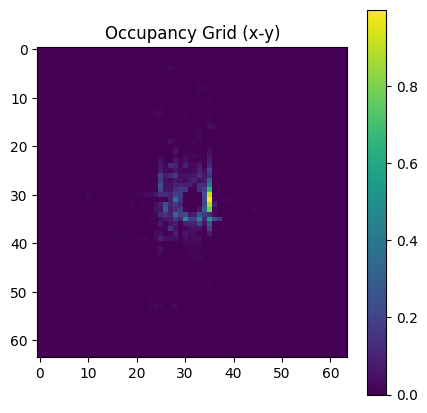

In [16]:

# occupancy grid 생성 (x-y 평면)
occ_image = point_cloud_to_occupancy(points, img_size=(64, 64), range_xy=[-50, 50, -50, 50])

# occupancy grid 시각화 (원본)
plt.figure(figsize=(5,5))
plt.imshow(occ_image)
plt.title("Occupancy Grid (x-y)")
plt.colorbar()
plt.show()

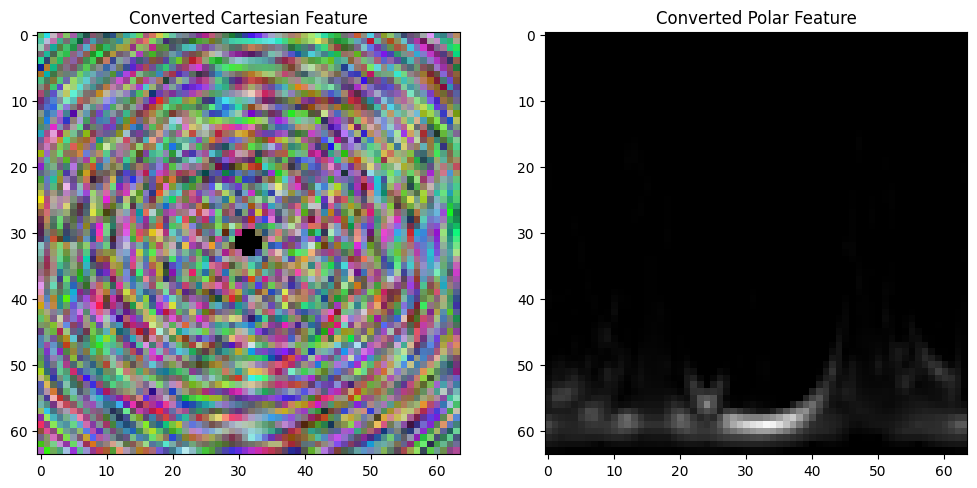

In [17]:
# occupancy grid를 tensor로 변환하여 3채널 cartesian 특징 맵 구성
cart_feat = torch.tensor(occ_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: (1,1,64,64)
cart_feat = cart_feat.repeat(1, 3, 1, 1)  # 3채널 확장

# polar 특징 맵은 실제 PointNet 등에서 추출된 특징이 들어가겠지만, 예시로 임의의 값 사용
# polar 특징 맵 크기: (batch, channel, polar_height, polar_width) = (1,3,64,512)
polar_feat = torch.rand(1, 3, 64, 64)

# 모듈 인스턴스 생성 (max_batch=1, mode='in' 사용)
polar2cart = Polar2Cart(polar_size=(64,64), cart_size=(64,64), center_drop_grid_size=3., max_batch=1, mode='in')
cart2polar = Cart2Polar(polar_size=(64,64), cart_size=(64,64), center_drop_grid_size=3., max_batch=1, mode='in')

# 변환 수행
converted_cart = polar2cart(polar_feat, cart_feat)
converted_polar = cart2polar(cart_feat, polar_feat)

# 변환 결과 시각화를 위해 tensor를 numpy array로 변환 (채널 순서 변경)
cart_image = converted_cart.squeeze(0).permute(1, 2, 0).detach().numpy()
polar_image = converted_polar.squeeze(0).permute(1, 2, 0).detach().numpy()

# 시각화: 변환된 Cartesian과 Polar 이미지 출력
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cart_image)
axs[0].set_title("Converted Cartesian Feature")
axs[1].imshow(polar_image)
axs[1].set_title("Converted Polar Feature")
plt.show()